In [1]:
library("ggplot2")
library("dplyr")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Motif score boxplot Fig 6c

In [177]:
df = read.csv('../plots/deeplift/motif_boxplots/ETS_HNF_REST_data.csv', header = TRUE)

In [178]:
head(df)

X,motif,score,task
0,ETS,0.0017323120,"K562, real motif"
1,ETS,0.0068530249,"K562, real motif"
2,ETS,0.0014950467,"K562, real motif"
3,ETS,0.0087563545,"K562, real motif"
4,ETS,0.0007821653,"K562, real motif"
5,ETS,0.0079582296,"K562, real motif"


Saving 8 x 8 in image


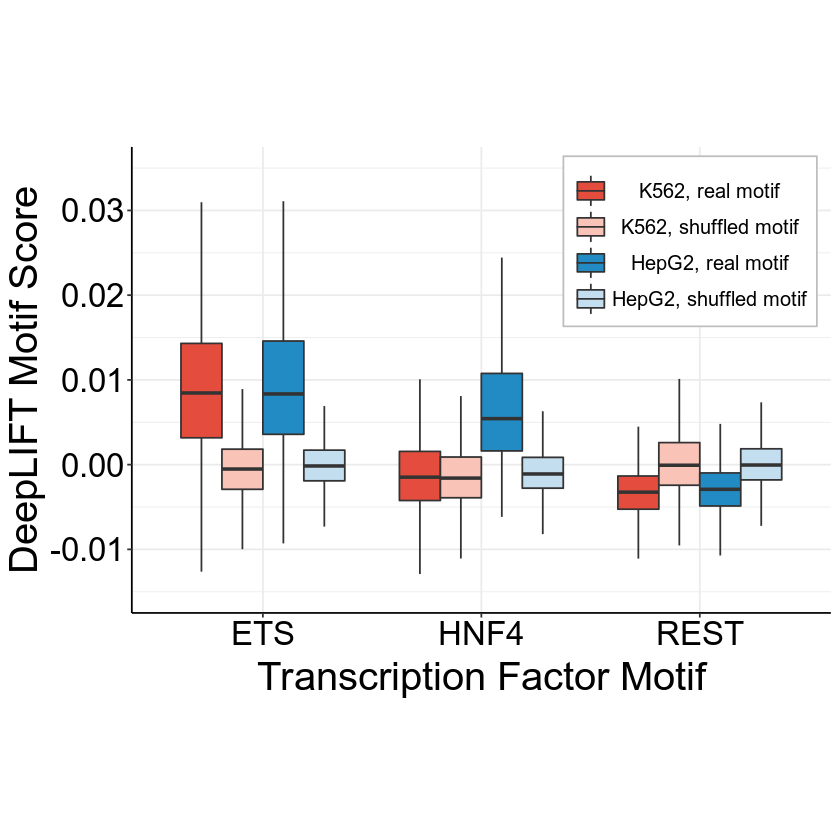

In [181]:
# cols <- c('#b92f2b', '#e7aa64', '#579352', '#4166a6'
taskOrder = c('K562, real motif', 'K562, shuffled motif', 'HepG2, real motif', 'HepG2, shuffled motif')
# sortedDf <- data.frame(df$task[order(match(df$task, taskOrder))])
sortedDf <- arrange(df, order(match(df$task, taskOrder)))
sortedDf$task <- factor(sortedDf$task, levels = taskOrder, ordered = TRUE)

scale <- c(1.2)

cols <- c('#E44D3D', '#F9C3B8', '#238BC3', '#c3deef')
p <- ggplot(sortedDf, aes(x = motif, y = score, fill = task)) +
        geom_boxplot(outlier.shape = NA) + 
        coord_cartesian(ylim = c(-0.015, 0.035)) +
        labs(x = 'Transcription Factor Motif', y = 'DeepLIFT Motif Score')
p <- p + scale_fill_manual(values=cols)
p <- p + theme_bw()
p <- p + theme(
#                panel.grid.major=element_line(colour='#F1F1F1'),
#                panel.grid.minor=element_line(colour='#F1F1F1'),
               panel.border = element_blank(),
#                panel.background=element_rect(size=0.5, colour='black')
            )
p <- p + theme(aspect.ratio=3/4.5)
p <- p + theme(
#                panel.grid.major = element_blank(), 
#                panel.grid.minor = element_blank(),
               axis.line = element_line(colour = "black"),
               legend.position=c(0.98,0.98),
               legend.title=element_blank(),
               legend.justification=c(1, 1),
               legend.key.size=unit(0.045, 'npc'),
               legend.text=element_text(size=12),
               legend.text.align = 0.5,
               legend.background=element_rect(fill='white', size=0.5, colour='grey'),
               axis.title=element_text(size=20*scale),
               axis.text=element_text(size=16.7*scale, colour='#000000'),
            )
# p <- p + guides(fill = guide_legend(label.position = "right", 
#                                     label.vjust = 0.5,
#                                     label.hjust = 0.0,
#                                     label = TRUE)) 
p <- p + theme(axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)))
p

ggsave("../plots/deeplift/motif_boxplots/ETS_HNF_REST_boxplot_correctBorder.png",
       scale = scale,
       plot = p,
       units = "in", dpi=1000)

In [ ]:
wilcox.test(df[df$motif %in% c('ETS'),]['score'])

In [228]:
head(df[which(df$motif %in% c('ETS'))])

ERROR: Error in `[.data.frame`(df, which(df$motif %in% c("ETS"))): undefined columns selected


In [232]:
head(df[df$motif %in% c('ETS'),]['score'])

score
0.0017323120
0.0068530249
0.0014950467
0.0087563545
0.0007821653
0.0079582296


# Sharpr scores at controls, motifs, and deepLIFT hits violinplot Fig 6e

In [2]:
df = read.csv('../data/sharprScores/controlMotifDeeplift_sharprScoreComparison_subsampled.csv', header = TRUE)
head(df)

X,score,type
0,-0.2535833,Control
1,-0.2848572,Control
2,-0.3473750,Control
3,-0.3647500,Control
4,-0.3830000,Control
5,-0.1446667,Control


In [3]:
## Summarizes data.
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr); library(dplyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

type,N,score,sd,se,ci
DeepLIFT Hit,2129,1.0778276,1.7009966,0.036865117,0.072295421
Motif Hit,105457,0.4872872,0.8187213,0.002521148,0.004941416
Control,205809,0.3502921,0.5676211,0.001251199,0.002452319


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


Saving 6.67 x 6.67 in image


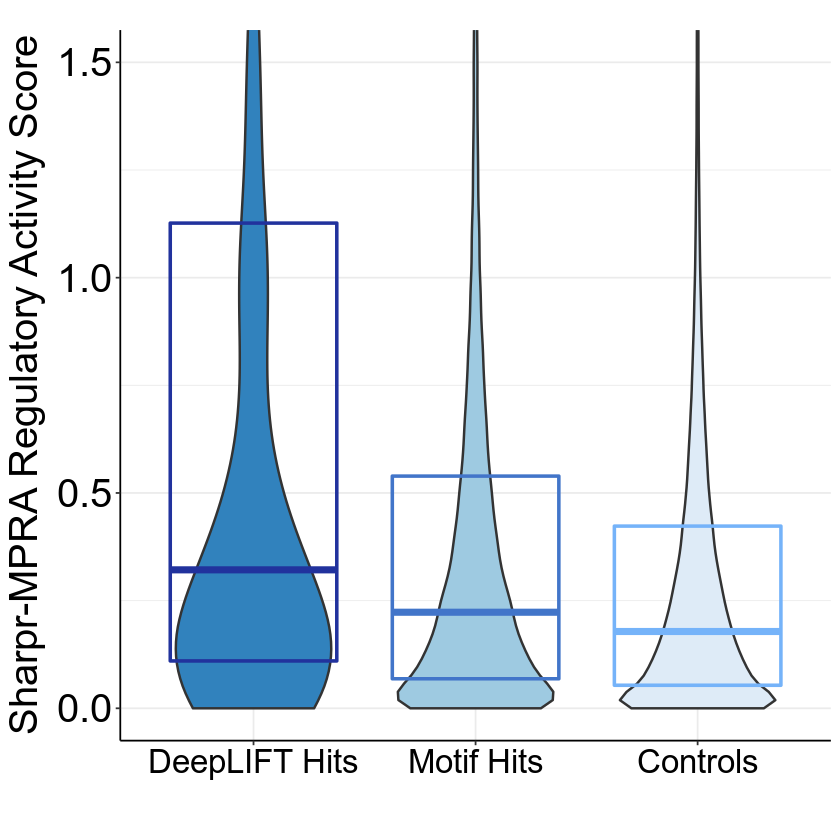

In [7]:
se <- function(x){sd(x)/sqrt(length(x))}

# cols <- c('#b92f2b', '#e7aa64', '#579352', '#4166a6'
typeOrder = c('DeepLIFT Hit', 'Motif Hit', 'Control')
# df <- arrange(df, order(match(df$type, typeOrder)))
df$score <- abs(df$score)
df$type <- factor(df$type, levels = typeOrder, ordered = TRUE)

# df_bar <- summarise(group_by(df, type), mean_score = mean(score), se_score = se(score))
df_bar <- summarySE(df, measurevar="score", groupvars=c("type"))
head(df_bar)

scale <- c(1)

cols <- c('#21329D', '#4275C9', '#75B3F9')
# p <- ggplot(df_bar, aes(x=type, y=score, fill=type)) +
#         geom_bar(stat="identity",
#                  colour='black') +
#         geom_errorbar(aes(ymin=score-se, ymax=score+se), width=.1) +
#         labs(x = '', y = 'Sharpr-MPRA Regulatory Activity Score')
p <- ggplot(df) +
        geom_violin(aes(x=type, y=score, fill=type), trim = TRUE, lwd=0.7, scale='width', width=0.7) + 
        scale_color_brewer(palette="Blues", direction = -1) +
        geom_boxplot(aes(x=type, y=score, color=type), outlier.shape = NA, fill=NA, coef=0, lwd=1) +
        scale_color_manual(values=cols) + 
#         scale_color_brewer(palette="Blues", direction = -1) +
#         scale_y_continuous(limits = c(0.0, 3.0)) +
        coord_cartesian(ylim = c(-0.0, 1.5)) +
        labs(x = '', y = 'Sharpr-MPRA Regulatory Activity Score')
p <- p + scale_x_discrete(labels=c('DeepLIFT Hits', 'Motif Hits', 'Controls'))
# p <- p + scale_fill_manual(values=cols)
p <- p + scale_fill_brewer(palette="Blues", direction = -1)
p <- p + theme_bw()
p <- p + theme(aspect.ratio=1)
p <- p + theme(
               axis.line = element_line(colour = "black"),
               axis.title=element_text(size=24*scale),
               axis.text.y=element_text(size=24*scale, colour='#000000'),
               axis.text.x=element_text(size=20*scale, colour='#000000'),
               panel.border = element_blank(),
#                panel.background=element_rect(size=0.3, colour='black')
            )
# p <- p + theme(panel.grid.minor = element_blank(),
#                panel.grid.major = element_blank())
p <- p + theme(axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)))
p <- p + guides(fill=FALSE, color=FALSE)
p

ggsave("../plots/deeplift/ETS_HNF_REST_violinplot.png",
       scale = scale,
       plot = p,
       units = "in", dpi=600)

In [35]:
abs(df$score)[c(1:10)]

[1] 0.25358334 0.28485718 0.34737498 0.36475003 0.38300002 0.14466666
 [7] 0.01509091 0.00000000 0.26107144 0.15180001

In [50]:
means <- aggregate(score ~ type, df, mean)
means

type,score
DeepLIFT Hit,1.0778276
Motif Hit,0.4872872
Control,0.3502921
